In [8]:
import pandas as pd
import os

def load_recovery_data(folder):
    path = os.path.join(folder, "recovery_log.csv")
    df = pd.read_csv(path, names=["Time", "Node", "Destination", "Event"])
    df["Time"] = pd.to_numeric(df["Time"])
    df.sort_values(by=["Node", "Destination", "Time"], inplace=True)
    return df

def compute_recovery_delay(df):
    rerr_df = df[df["Event"] == "RERR_SENT"]
    rreq_df = df[df["Event"] == "RREQ_SENT"]
    rrep_df = df[df["Event"] == "RREP_RECV"]

    merged = pd.merge(rerr_df, rreq_df, on=["Node", "Destination"], suffixes=("_RERR", "_RREQ"))
    merged = pd.merge(merged, rrep_df, on=["Node", "Destination"])
    merged.rename(columns={"Time": "Time_RREP"}, inplace=True)
    merged["RecoveryDelay"] = merged["Time_RREP"] - merged["Time_RERR"]

    result = merged[["Node", "Destination", "Time_RERR", "Time_RREQ", "Time_RREP", "RecoveryDelay"]]
    return result

# 경로 설정
legacy_path = "Legacy/"
proposed_path = "Proposed/"

# 데이터 불러오기
legacy_df = load_recovery_data(legacy_path)
proposed_df = load_recovery_data(proposed_path)

# 복구 지연 시간 계산
legacy_result = compute_recovery_delay(legacy_df)
proposed_result = compute_recovery_delay(proposed_df)

# 평균 복구 지연 시간 출력
print("Legacy 평균 복구 지연 시간:", legacy_result["RecoveryDelay"].mean())
print("Proposed 평균 복구 지연 시간:", proposed_result["RecoveryDelay"].mean())

# 필요한 경우 CSV로 저장
legacy_result.to_csv("legacy_recovery_analysis.csv", index=False)
proposed_result.to_csv("proposed_recovery_analysis.csv", index=False)


Legacy 평균 복구 지연 시간: nan
Proposed 평균 복구 지연 시간: 0.13167331221575296


In [12]:
# summary_path = "/path/to/Proposed/recovery_result.csv"
# → 이 파일이 실제로 없음 (복구 성공 결과 CSV 저장 안 된 상태)

# 해결 방법: recovery_log.csv로부터 직접 처리해서 summary 생성

import pandas as pd
import os

def extract_success_only(raw_log_path):
    df = pd.read_csv(raw_log_path, names=["Time", "Node", "Destination", "Event"])
    df["Time"] = pd.to_numeric(df["Time"])
    df = df.sort_values(by=["Node", "Destination", "Time"])

    rerr = df[df["Event"] == "RERR_SENT"]
    rreq = df[df["Event"] == "RREQ_SENT"]
    rrep = df[df["Event"] == "RREP_RECV"]

    merged = pd.merge(rerr, rreq, on=["Node", "Destination"], suffixes=("_RERR", "_RREQ"))
    merged = pd.merge(merged, rrep, on=["Node", "Destination"])
    merged.rename(columns={"Time": "Time_RREP"}, inplace=True)
    merged["RecoveryDelay"] = merged["Time_RREP"] - merged["Time_RERR"]

    return merged[["Node", "Destination", "Time_RERR", "Time_RREQ", "Time_RREP", "RecoveryDelay"]]

def compute_stats(df):
    return {
        "count": len(df),
        "avg": df["RecoveryDelay"].mean(),
        "min": df["RecoveryDelay"].min(),
        "max": df["RecoveryDelay"].max()
    }

# 파일 경로 수정
raw_log_path = "Proposed/recovery_log.csv"

# 처리
df_success = extract_success_only(raw_log_path)
df_success.to_csv("Proposed/recovery_result.csv", index=False)

stats = compute_stats(df_success)
print("복구 수:", stats["count"])
print("평균 지연 시간:", stats["avg"])
print("최소:", stats["min"])
print("최대:", stats["max"])


복구 수: 4
평균 지연 시간: 0.13167331221575296
최소: 0.008595680471998435
최대: 0.1798089384940056


In [13]:
import pandas as pd

def load_routing_log(path):
    df = pd.read_csv(path)
    df.columns = ["Time", "Node", "Destination", "Previous_LifeTime", "New_LifeTime",
                  "Previous_NextHop", "New_NextHop", "Previous_HopCount", "New_HopCount"]
    return df

def count_route_updates(df):
    return df["Node"].value_counts().sort_index()

def compare_route_update_counts(path_legacy, path_proposed, output_csv="routing_update_comparison.csv"):
    df_legacy = load_routing_log(path_legacy)
    df_proposed = load_routing_log(path_proposed)

    legacy_counts = count_route_updates(df_legacy)
    proposed_counts = count_route_updates(df_proposed)

    df_compare = pd.DataFrame({
        "Legacy_Updates": legacy_counts,
        "Proposed_Updates": proposed_counts
    }).fillna(0).astype(int)

    df_compare.loc["TOTAL"] = df_compare.sum()
    df_compare.to_csv(output_csv)
    return df_compare

# 사용 예시
# compare_route_update_counts("Legacy/aodv_routing_log.csv", "Proposed/aodv_routing_log.csv")


In [14]:
import pandas as pd

def load_and_debug_routing_log(path):
    df = pd.read_csv(path)
    print("🔍 파일 경로:", path)
    print("📌 컬럼 목록:", list(df.columns))
    print("📊 전체 행 수:", len(df))
    print("🧾 상위 5개 행:")
    print(df.head())
    return df

# 사용 예시
df_legacy = load_and_debug_routing_log("Legacy/aodv_routing_log.csv")
df_proposed = load_and_debug_routing_log("Proposed/aodv_routing_log.csv")


🔍 파일 경로: Legacy/aodv_routing_log.csv
📌 컬럼 목록: ['Time', 'Node', 'Destination', 'Previous_LifeTime', 'New_LifeTime', 'Previous_NextHop', 'New_NextHop', 'Previous_HopCount', 'New_HopCount']
📊 전체 행 수: 678015
🧾 상위 5개 행:
        Time       Node Destination  Previous_LifeTime  New_LifeTime  \
0  30.003734  node[107]    10.0.0.9          33.003734     35.523734   
1  30.003734  node[130]    10.0.0.9          33.003734     35.523734   
2  30.003734  node[229]    10.0.0.9          33.003734     35.523734   
3  30.003734  node[244]    10.0.0.9          33.003734     35.523734   
4  30.003734   node[35]    10.0.0.9          33.003734     35.523734   

  Previous_NextHop New_NextHop  Previous_HopCount  New_HopCount  
0         10.0.0.9    10.0.0.9                  1             1  
1         10.0.0.9    10.0.0.9                  1             1  
2         10.0.0.9    10.0.0.9                  1             1  
3         10.0.0.9    10.0.0.9                  1             1  
4         10.0.0.9    

In [16]:
import pandas as pd

def load_rreq_log(path):
    df = pd.read_csv(path, header=None, names=["Node"])
    return df

def compute_rreq_stats(df):
    total = len(df)
    per_node = df["Node"].value_counts().sort_index()
    return total, per_node

def compare_rreq_stats(path_legacy, path_proposed, output_csv="rreq_stats_comparison.csv"):
    df_legacy = load_rreq_log(path_legacy)
    df_proposed = load_rreq_log(path_proposed)

    total_legacy, per_node_legacy = compute_rreq_stats(df_legacy)
    total_proposed, per_node_proposed = compute_rreq_stats(df_proposed)

    df_compare = pd.DataFrame({
        "Legacy_RREQs": per_node_legacy,
        "Proposed_RREQs": per_node_proposed
    }).fillna(0).astype(int)

    df_compare.loc["TOTAL"] = [total_legacy, total_proposed]
    df_compare.to_csv(output_csv)
    return df_compare

# 사용 예시
compare_rreq_stats("Legacy/rreqCount.txt", "Proposed/rreqCount.txt")


,Legacy_RREQs,Proposed_RREQs
Node,,
node[0],4,13
node[100],47,21
node[101],80,96
node[102],141,337
node[103],94,63
...,...,...
node[98],14,134
node[99],74,205
node[9],39,9


In [17]:
import pandas as pd

# 경로 갱신 로그 로드
def load_routing_log(path):
    df = pd.read_csv(path)
    df.columns = [
        "Time", "Node", "Destination", "Previous_LifeTime", "New_LifeTime",
        "Previous_NextHop", "New_NextHop", "Previous_HopCount", "New_HopCount"
    ]
    return df

# 변화 유형 분류
def classify_change_types(df):
    df["HopChange"] = df["Previous_HopCount"] != df["New_HopCount"]
    df["NextHopChange"] = df["Previous_NextHop"] != df["New_NextHop"]
    df["LifeTimeChange"] = df["Previous_LifeTime"] != df["New_LifeTime"]
    df["ChangeType"] = df.apply(
        lambda row: "Hop+NextHop" if row["HopChange"] and row["NextHopChange"]
        else "HopOnly" if row["HopChange"]
        else "NextHopOnly" if row["NextHopChange"]
        else "LifeTimeOnly" if row["LifeTimeChange"]
        else "NoChange",
        axis=1
    )
    return df

# 변화 유형 요약
def summarize_change_types(df):
    return df["ChangeType"].value_counts().sort_index()

# 비교 실행
def compare_change_type_stats(path_legacy, path_proposed):
    df_legacy = classify_change_types(load_routing_log(path_legacy))
    df_proposed = classify_change_types(load_routing_log(path_proposed))

    summary_legacy = summarize_change_types(df_legacy)
    summary_proposed = summarize_change_types(df_proposed)

    df_compare = pd.DataFrame({
        "Legacy": summary_legacy,
        "Proposed": summary_proposed
    }).fillna(0).astype(int)

    return df_compare

# 사용 예시
result = compare_change_type_stats("Legacy/aodv_routing_log.csv", "Proposed/aodv_routing_log.csv")
print(result)


              Legacy  Proposed
ChangeType                    
Hop+NextHop     1311      3958
HopOnly          288       661
LifeTimeOnly  675482    681442
NextHopOnly      934      2141


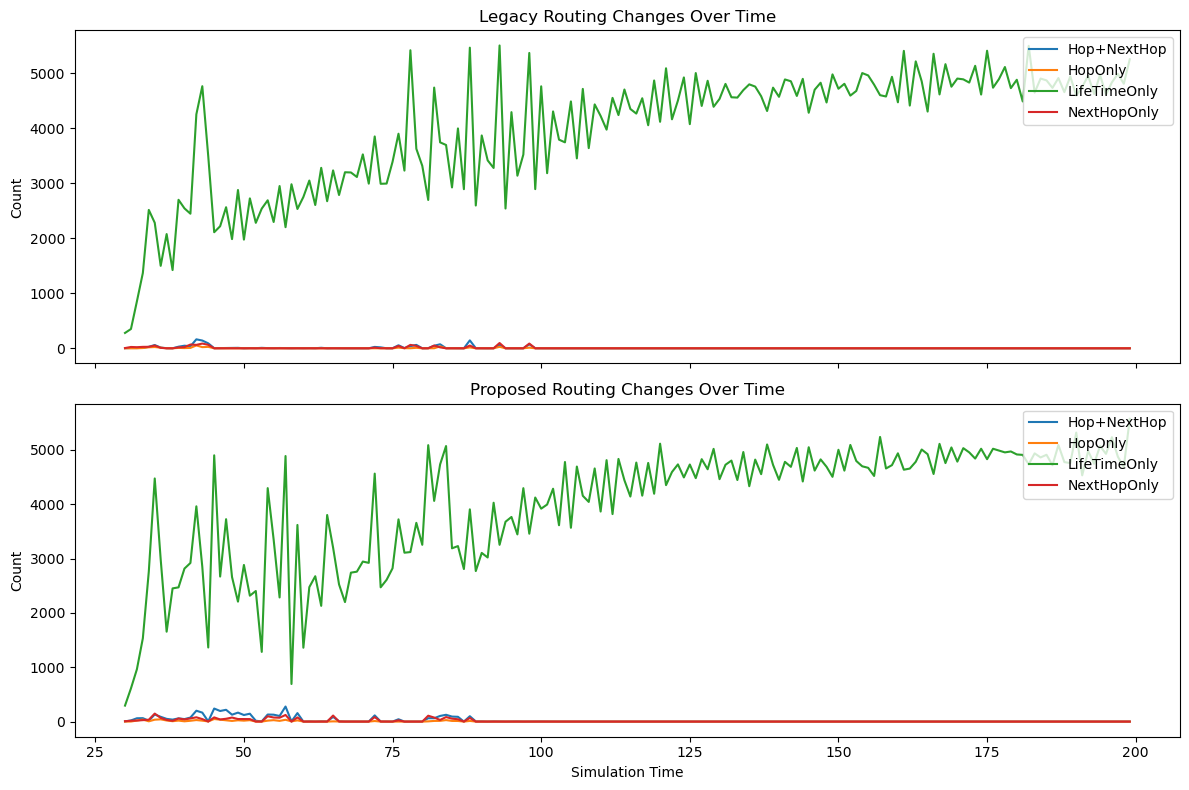

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

def load_and_classify(path):
    df = pd.read_csv(path)
    df.columns = [
        "Time", "Node", "Destination", "Previous_LifeTime", "New_LifeTime",
        "Previous_NextHop", "New_NextHop", "Previous_HopCount", "New_HopCount"
    ]
    df["Time"] = df["Time"].astype(float)
    df["HopChange"] = df["Previous_HopCount"] != df["New_HopCount"]
    df["NextHopChange"] = df["Previous_NextHop"] != df["New_NextHop"]
    df["LifeTimeChange"] = df["Previous_LifeTime"] != df["New_LifeTime"]
    df["ChangeType"] = df.apply(
        lambda row: "Hop+NextHop" if row["HopChange"] and row["NextHopChange"]
        else "HopOnly" if row["HopChange"]
        else "NextHopOnly" if row["NextHopChange"]
        else "LifeTimeOnly" if row["LifeTimeChange"]
        else "NoChange",
        axis=1
    )
    return df

def count_by_time(df, bin_size=1.0):
    df["TimeBin"] = (df["Time"] // bin_size) * bin_size
    return df.groupby(["TimeBin", "ChangeType"]).size().unstack(fill_value=0)

def plot_time_series(df_legacy, df_proposed):
    fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
    df_legacy.plot(ax=axes[0], title="Legacy Routing Changes Over Time")
    df_proposed.plot(ax=axes[1], title="Proposed Routing Changes Over Time")
    for ax in axes:
        ax.set_ylabel("Count")
        ax.legend(loc="upper right")
    plt.xlabel("Simulation Time")
    plt.tight_layout()
    plt.show()

# 사용 예시
legacy = load_and_classify("Legacy/aodv_routing_log.csv")
proposed = load_and_classify("Proposed/aodv_routing_log.csv")
legacy_ts = count_by_time(legacy)
proposed_ts = count_by_time(proposed)
plot_time_series(legacy_ts, proposed_ts)


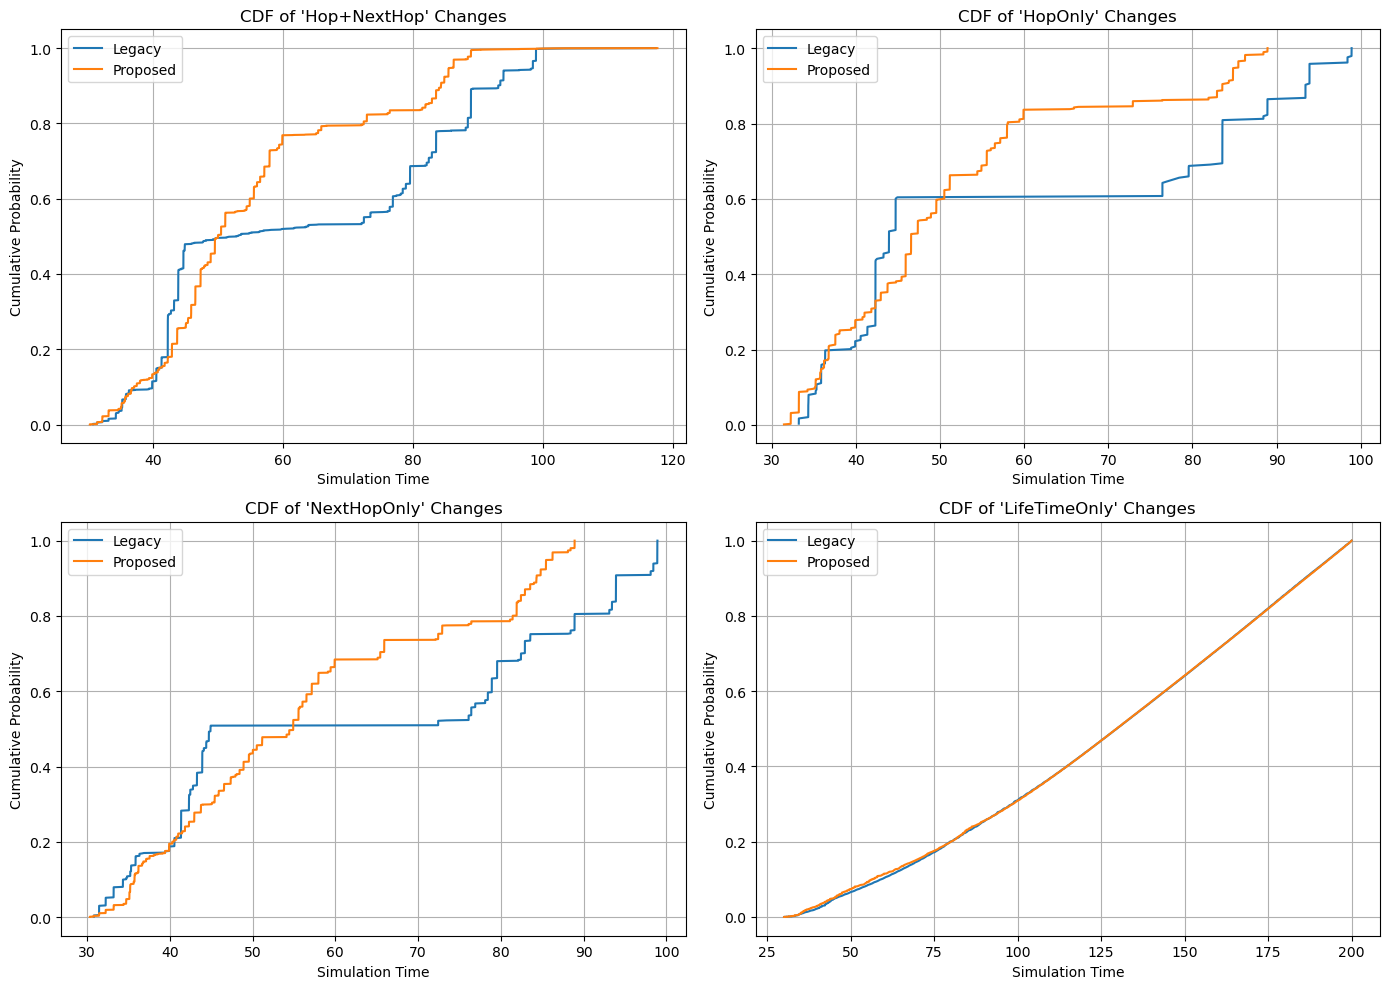

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def load_routing_log(path):
    df = pd.read_csv(path)
    df.columns = ["Time", "Node", "Destination", "Previous_LifeTime", "New_LifeTime", "Previous_NextHop", "New_NextHop", "Previous_HopCount", "New_HopCount"]
    return df

def classify_change_type(df):
    def get_change_type(row):
        hop_changed = row["Previous_HopCount"] != row["New_HopCount"]
        nhop_changed = row["Previous_NextHop"] != row["New_NextHop"]
        if hop_changed and nhop_changed:
            return "Hop+NextHop"
        elif hop_changed:
            return "HopOnly"
        elif nhop_changed:
            return "NextHopOnly"
        else:
            return "LifeTimeOnly"
    df["ChangeType"] = df.apply(get_change_type, axis=1)
    return df

def plot_cdf(df_legacy, df_proposed):
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))
    change_types = ["Hop+NextHop", "HopOnly", "NextHopOnly", "LifeTimeOnly"]
    colors = ['blue', 'orange', 'red', 'green']
    axs = axs.flatten()

    for i, ctype in enumerate(change_types):
        for label, df in [("Legacy", df_legacy), ("Proposed", df_proposed)]:
            times = df[df["ChangeType"] == ctype]["Time"].sort_values()
            y = np.arange(1, len(times)+1) / len(times)
            axs[i].plot(times, y, label=label)

        axs[i].set_title(f"CDF of '{ctype}' Changes")
        axs[i].set_xlabel("Simulation Time")
        axs[i].set_ylabel("Cumulative Probability")
        axs[i].legend()
        axs[i].grid(True)

    plt.tight_layout()
    plt.show()

legacy_df = classify_change_type(load_routing_log("Legacy/aodv_routing_log.csv"))
proposed_df = classify_change_type(load_routing_log("Proposed/aodv_routing_log.csv"))
plot_cdf(legacy_df, proposed_df)


In [22]:
import pandas as pd

def estimate_success_rate_after_change_from_recovery_log(
    routing_log_path, recovery_log_path, change_type="Hop+NextHop", interval=1.0
):
    # 라우팅 로그 불러오기 및 ChangeType 분류
    df = pd.read_csv(routing_log_path)
    df.columns = [
        "Time", "Node", "Destination", "Previous_LifeTime", "New_LifeTime",
        "Previous_NextHop", "New_NextHop", "Previous_HopCount", "New_HopCount"
    ]
    df["HopChange"] = df["Previous_HopCount"] != df["New_HopCount"]
    df["NextHopChange"] = df["Previous_NextHop"] != df["New_NextHop"]
    df["LifeTimeChange"] = df["Previous_LifeTime"] != df["New_LifeTime"]
    df["ChangeType"] = df.apply(
        lambda row: "Hop+NextHop" if row["HopChange"] and row["NextHopChange"]
        else "HopOnly" if row["HopChange"]
        else "NextHopOnly" if row["NextHopChange"]
        else "LifeTimeOnly" if row["LifeTimeChange"]
        else "NoChange",
        axis=1
    )
    changed_df = df[df["ChangeType"] == change_type][["Time", "Node", "Destination"]]

    # recovery_log에서 RREP_RECV만 추출
    recovery_df = pd.read_csv(recovery_log_path, header=None, names=["Time", "Node", "Destination", "Event"])
    rrep_df = recovery_df[recovery_df["Event"] == "RREP_RECV"]

    success = 0
    total = 0

    for _, row in changed_df.iterrows():
        t_start = row["Time"]
        t_end = t_start + interval
        dest = str(row["Destination"])

        matched = rrep_df[
            (rrep_df["Destination"].astype(str) == dest) &
            (rrep_df["Time"] >= t_start) & (rrep_df["Time"] <= t_end)
        ]

        total += 1
        if not matched.empty:
            success += 1

    rate = (success / total) * 100 if total > 0 else 0
    return rate

# 호출
legacy_rate = estimate_success_rate_after_change_from_recovery_log(
    "Legacy/aodv_routing_log.csv", "Legacy/recovery_log.csv"
)
proposed_rate = estimate_success_rate_after_change_from_recovery_log(
    "Proposed/aodv_routing_log.csv", "Proposed/recovery_log.csv"
)

print(f"Legacy Hop+NextHop 변화 후 RREP 수신률: {legacy_rate:.2f}%")
print(f"Proposed Hop+NextHop 변화 후 RREP 수신률: {proposed_rate:.2f}%")


Legacy Hop+NextHop 변화 후 RREP 수신률: 11.75%
Proposed Hop+NextHop 변화 후 RREP 수신률: 21.45%


In [23]:
# 기존 함수 재사용
def estimate_success_rate_after_change_from_recovery_log(
    routing_log_path, recovery_log_path, change_type, interval=1.0
):
    df = pd.read_csv(routing_log_path)
    df.columns = [
        "Time", "Node", "Destination", "Previous_LifeTime", "New_LifeTime",
        "Previous_NextHop", "New_NextHop", "Previous_HopCount", "New_HopCount"
    ]
    df["HopChange"] = df["Previous_HopCount"] != df["New_HopCount"]
    df["NextHopChange"] = df["Previous_NextHop"] != df["New_NextHop"]
    df["LifeTimeChange"] = df["Previous_LifeTime"] != df["New_LifeTime"]
    df["ChangeType"] = df.apply(
        lambda row: "Hop+NextHop" if row["HopChange"] and row["NextHopChange"]
        else "HopOnly" if row["HopChange"]
        else "NextHopOnly" if row["NextHopChange"]
        else "LifeTimeOnly" if row["LifeTimeChange"]
        else "NoChange",
        axis=1
    )
    changed_df = df[df["ChangeType"] == change_type][["Time", "Node", "Destination"]]

    recovery_df = pd.read_csv(recovery_log_path, header=None, names=["Time", "Node", "Destination", "Event"])
    rrep_df = recovery_df[recovery_df["Event"] == "RREP_RECV"]

    success = 0
    total = 0

    for _, row in changed_df.iterrows():
        t_start = row["Time"]
        t_end = t_start + interval
        dest = str(row["Destination"])

        matched = rrep_df[
            (rrep_df["Destination"].astype(str) == dest) &
            (rrep_df["Time"] >= t_start) & (rrep_df["Time"] <= t_end)
        ]

        total += 1
        if not matched.empty:
            success += 1

    rate = (success / total) * 100 if total > 0 else 0
    return rate


In [24]:
types = ["HopOnly", "NextHopOnly"]

for change in types:
    legacy = estimate_success_rate_after_change_from_recovery_log(
        "Legacy/aodv_routing_log.csv", "Legacy/recovery_log.csv", change_type=change
    )
    proposed = estimate_success_rate_after_change_from_recovery_log(
        "Proposed/aodv_routing_log.csv", "Proposed/recovery_log.csv", change_type=change
    )

    print(f"[{change}]")
    print(f"  Legacy   : {legacy:.2f}%")
    print(f"  Proposed : {proposed:.2f}%\n")


[HopOnly]
  Legacy   : 18.06%
  Proposed : 30.11%

[NextHopOnly]
  Legacy   : 11.88%
  Proposed : 17.28%

